<a href="https://colab.research.google.com/github/tanmaylaud/network-model-python/blob/master/NetworkModeling_GPU_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Modeling with SEIRS+ Notebook 

In [2]:
# check gpu type
!nvidia-smi

import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

# your dolphin is broken, please reset & try again
if device_name != b'Tesla T4':
  raise Exception("""Unfortunately this instance does not have a T4 GPU.

    Please make sure you've configured Colab to request a GPU instance type.

    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...""")

# got a T4, good to go 
else:
  print('Woo! You got the right kind of GPU!')

Sun Sep 20 17:42:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In order, this script will:
Install most recent Miniconda release compatible with Google Colab’s Python install (3.6.7)
Remove any incompatible files
Install RAPIDS libraries (cuDF, cuML cuGraph & cuSpatial)
Sets necessary environment variables
Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [5]:
!pip install networkx seirsplus
!git clone https://github.com/tanmaylaud/network-model-python.git

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for seirsplus: filename=seirsplus-1.0.9-cp36-none-any.whl size=64634 sha256=3d7f1ef1992c58c1ee61cca41f3bd0aaffba3dd998bbeb945f32fa711a8b2f61
  Stored in directory: /root/.cache/pip/wheels/f0/83/18/7b9b20364e2740f54c21cf5b3ebfde5a8a93071e098782c705
Successfully built seirsplus
Cloning into 'network-model-python'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 600 (delta 12), reused 9 (delta 6), pack-reused 574
Receiving objects: 100% (600/600), 33.67 MiB | 30.00 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [9]:
!cp -r ./network-model-python/* ./

In [60]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus_gpu.models import *
from seirsplus_gpu.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

### 1) Load base graph for Moria

In [44]:
graph, nodes_per_struct = load_graph("Moria_wNeighbors")

In [45]:
graph, nodes_per_struct[:10]

(<networkx.classes.graph.Graph at 0x7f471d372630>,
 [[5359, 6786, 11341, 12772, 16439, 17362],
  [1725, 4150, 9846, 10264, 10775, 16305, 18271],
  [3525, 5466, 9174, 10999, 13126, 14208, 16274, 17424, 18010],
  [3937, 9445, 15445, 15446],
  [2944, 7910, 10523, 12494, 16665],
  [5339, 10767, 12726, 15207, 17421, 18315, 18410],
  [2373, 7673, 9205, 16819],
  [587, 2395, 2953, 4030, 8569, 10641, 12194, 14204, 14656],
  [810, 1805, 5202, 5204, 8552, 12428, 12654, 13949, 14363],
  [584, 4073, 9224, 14603, 18566]])

#### 1.1) We will add a general food queue which represents the current state of the camp

In [46]:
food_weight = 0.407
graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")

### 2) Plot the basic network degrees

Min degree: 0 Max degree: 187


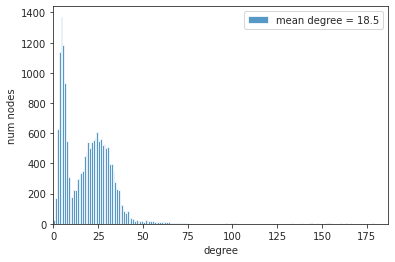

In [53]:
# Degrees without food queue, just neighbors
min_G, max_G = min_degree(graph), max_degree(graph)
print("Min degree:", min_G, "Max degree:", max_G)
plot_degree_distn2(graph, max_degree=max_G)

Min degree: 0 Max degree: 197


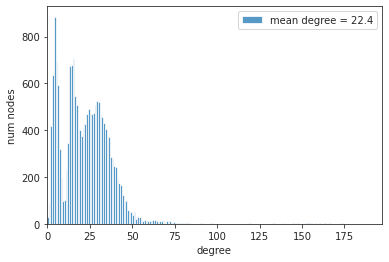

In [54]:
# Degrees with 1 food queue
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
plot_degree_distn2(graph_1fq, max_degree=max_G)

### 3) Create node groups of 10 year age bucket to track the results

In [55]:
node_groups=create_node_groups(graph)

### 4) Define SEIRS model parameters

In [56]:
transmission_rate = 1.28
progression_rate = round(1/5.1, 3)
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = round(1/11.4, 3) #1/6.3 # From Tucker Model
# crit_rate = 0.3 # From camp_params
crit_rate = list((sample_pop["death_rate"] / sample_pop["prob_symptomatic"]) / sample_pop["prob_hospitalisation"])
death_rate = 0.75

prob_global_contact = 0.2
prob_quarantine_global_contact = 1

# prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_death = list(sample_pop["death_rate"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 1

In [62]:
g = cu.Graph()
g.

### 5) Running the base model

In [61]:
# Model construction
ref_model = ExtSEIRSNetworkModel3(G=graph_1fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

AttributeError: ignored

In [33]:
t_steps = 100
node_states, simulation_results = run_simulation(ref_model, t_steps)

  0%|          | 0/100 [00:00<?, ?it/s]

Running simulation for 100 steps...



 63%|██████▎   | 63/100 [12:43<07:28, 12.12s/it]


KeyboardInterrupt: ignored

In [ ]:
# Model name for storage + store the model params in csv
i = 0  # This is a number assigned to identify a particular network
param_combo_i = 0  # This is a number assigned to identify a particular combination of parameters
fig_name = f"BaseSympModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)

In [ ]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [ ]:
# Construct results dataframe
output_df = results_to_df(simulation_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18696.0      3.0                      0.0                   1.0   
1        18695.0      4.0                      0.0                   1.0   
2        18694.0      5.0                      0.0                   0.0   
3        18694.0      4.0                      1.0                   0.0   
4        18693.0      5.0                      1.0                   0.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        1.0         0.0   
3                      0.0           0.0        1.0         0.0   
4                      0.0           0.0        1.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18048.0       652.0   
196                    0.0           0.0    18048.0       652.0   
197                    0.0           0.0    18048.0       652.0   
198                    0.0           0.0    18048.0       652.0   
199                    0.0           0.0    18048.0       652.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          3     1  
1          4     2  
2          6     3  
3          7     4  
4          8     5  
..       ...   ...  
195    75476   196  
196    75476   197  
197    75476   198  
198    75476   199  
199    75476   200  

[200 rows x 13 columns]

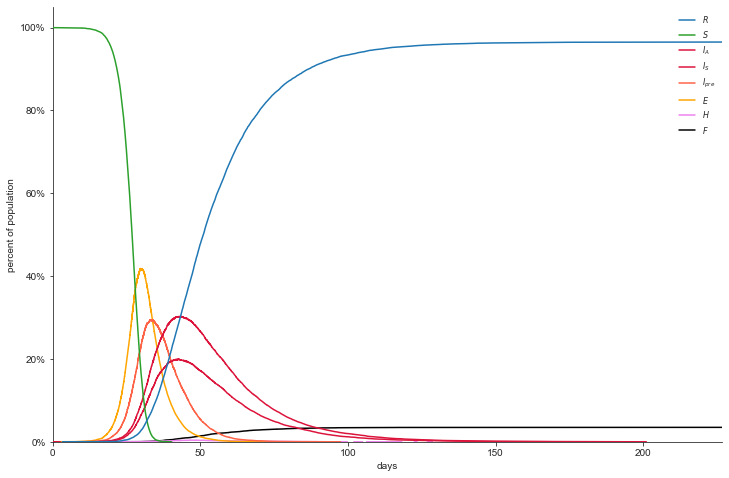

In [ ]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

### 6) Define Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

#### 6.1) First, define the intervention graphs

In [ ]:
# This is social distancing within the food queue 
distancing_graph = remove_edges_from_graph(graph_1fq, scale=10, edge_label_list=["food"], min_num_edges=4)

# This also includes neighbor/friendship edges
quarantine_graph = remove_edges_from_graph(graph_1fq, scale=2, edge_label_list=["food", "friendship"], min_num_edges=2)

# Create graphs with multiple sectoring of food queues - in this case, 1 and 2 queues per each block (4 and 8 food queues respectively)
graph_4fq = create_multiple_food_queues(graph, 1, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])
graph_8fq = create_multiple_food_queues(graph, 2, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])

# Create quarantine graphs for the sectored graphs
quarantine_graph_4fq = remove_edges_from_graph(graph_4fq, scale=2, edge_label_list=[f"food_{i}" for i in range(4)] + ["friendship"], min_num_edges=2)
quarantine_graph_8fq = remove_edges_from_graph(graph_8fq, scale=2, edge_label_list=[f"food_{i}" for i in range(8)] + ["friendship"], min_num_edges=2)

Min degree: 0 Max degree: 189


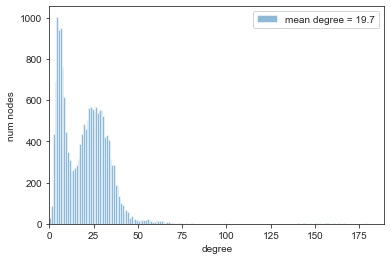

In [ ]:
min_D, max_D = min_degree(distancing_graph), max_degree(distancing_graph)
print("Min degree:", min_D, "Max degree:", max_D)

# As we can see, there isn't much of a difference when we only cut food-queue interactions, 
# which means we need a harder distancing policy
plot_degree_distn(distancing_graph, max_degree=max_D)

Min degree: 0 Max degree: 18


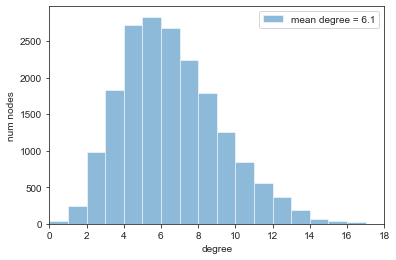

In [ ]:
min_Q, max_Q = min_degree(quarantine_graph), max_degree(quarantine_graph)
print("Min degree:", min_Q, "Max degree:", max_Q)

plot_degree_distn(quarantine_graph, max_degree=max_Q)

Min degree: 0 Max degree: 190


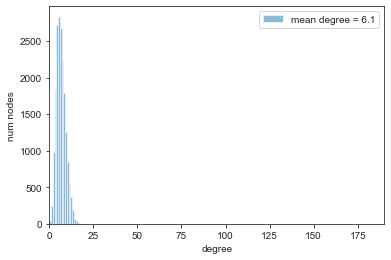

In [ ]:
# 4 food queues 
min_4fq, max_4fq = min_degree(graph_4fq), max_degree(graph_4fq)
print("Min degree:", min_4fq, "Max degree:", max_4fq)

plot_degree_distn(quarantine_graph, max_degree=max_4fq)

Min degree: 0 Max degree: 187


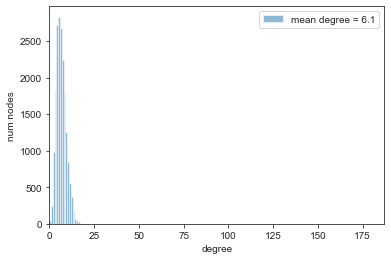

In [ ]:
# 8 food queues
min_8fq, max_8fq = min_degree(graph_8fq), max_degree(graph_8fq)
print("Min degree:", min_8fq, "Max degree:", max_8fq)

plot_degree_distn(quarantine_graph, max_degree=max_8fq)

#### 6.2) Construct the checkpoints

In [ ]:
interventions = Interventions()
reduction_percentage = 0.5

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_1fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_1fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

### 7) Running the model with interventions

In [ ]:
# Model construction with interventions on the model with 1 food queue
interventions_model = ExtSEIRSNetworkModel(G=graph_1fq, Q=quarantine_graph, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
intervention_node_states, intervention_results = run_simulation(interventions_model, t_steps, checkpoints)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [30:25<00:00,  9.13s/it]  


In [ ]:
# Model name for storage + store the model params in csv
i, param_combo_i = 0, 0
fig_name = f"InterventionsBaseModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18698.0      0.0                      1.0                   1.0   
1        18697.0      1.0                      1.0                   1.0   
2        18695.0      3.0                      1.0                   1.0   
3        18694.0      3.0                      1.0                   1.0   
4        18690.0      7.0                      1.0                   1.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        0.0         0.0   
3                      1.0           0.0        0.0         0.0   
4                      1.0           0.0        0.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18012.0       688.0   
196                    0.0           0.0    18012.0       688.0   
197                    0.0           0.0    18012.0       688.0   
198                    0.0           0.0    18012.0       688.0   
199                    0.0           0.0    18012.0       688.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          2     1  
1          3     2  
2          5     3  
3          8     4  
4         12     5  
..       ...   ...  
195    75518   196  
196    75518   197  
197    75518   198  
198    75518   199  
199    75518   200  

[200 rows x 13 columns]

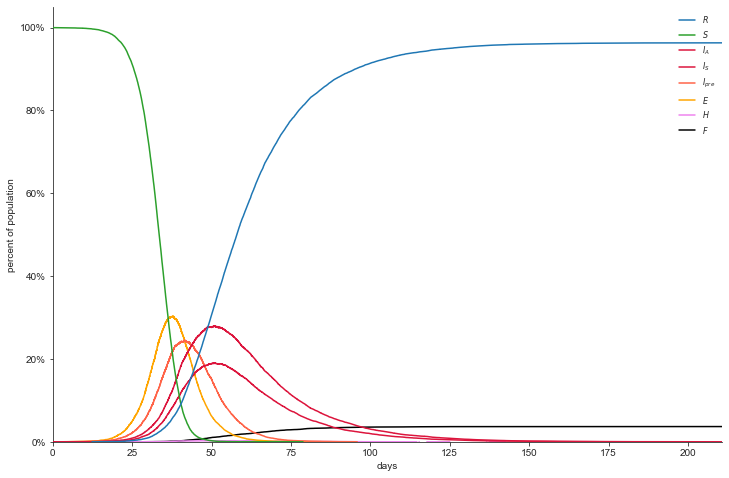

In [ ]:
fig, ax = interventions_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.1) Running the base model with multiple food queues

In [ ]:
# Model construction for multiple food queues but no more interventions
model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
node_states, simulation_results_4fq = run_simulation(model_4fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [22:35<00:00,  6.78s/it] 


In [ ]:
# Model name for storage
food_queue_number = 4
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
			

In [ ]:
output_df = results_to_df(simulation_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18697.0      2.0                      0.0                   1.0   
1        18696.0      3.0                      0.0                   1.0   
2        18694.0      4.0                      1.0                   1.0   
3        18693.0      4.0                      2.0                   1.0   
4        18688.0      8.0                      3.0                   1.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        0.0         0.0   
3                      0.0           0.0        0.0         0.0   
4                      0.0           0.0        0.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18057.0       643.0   
196                    0.0           0.0    18057.0       643.0   
197                    0.0           0.0    18057.0       643.0   
198                    0.0           0.0    18057.0       643.0   
199                    0.0           0.0    18057.0       643.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          2     1  
1          3     2  
2          6     3  
3          8     4  
4         14     5  
..       ...   ...  
195    75466   196  
196    75466   197  
197    75466   198  
198    75466   199  
199    75466   200  

[200 rows x 13 columns]

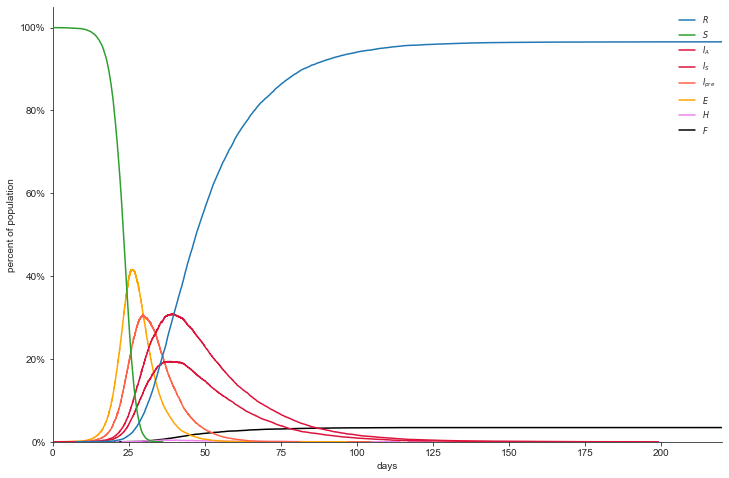

In [ ]:
fig, ax = model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
t_steps = 200
node_states, simulation_results_8fq = run_simulation(model_8fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [33:14<00:00,  9.97s/it]   


In [ ]:
food_queue_number = 8
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
	

In [ ]:
output_df = results_to_df(simulation_results_8fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18696.0      3.0                      0.0                   1.0   
1        18694.0      4.0                      1.0                   1.0   
2        18693.0      5.0                      1.0                   1.0   
3        18690.0      5.0                      4.0                   1.0   
4        18683.0     12.0                      4.0                   1.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        0.0         0.0   
3                      0.0           0.0        0.0         0.0   
4                      0.0           0.0        0.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18024.0       676.0   
196                    0.0           0.0    18024.0       676.0   
197                    0.0           0.0    18024.0       676.0   
198                    0.0           0.0    18024.0       676.0   
199                    0.0           0.0    18024.0       676.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          3     1  
1          6     2  
2          7     3  
3         13     4  
4         20     5  
..       ...   ...  
195    75500   196  
196    75500   197  
197    75500   198  
198    75500   199  
199    75500   200  

[200 rows x 13 columns]

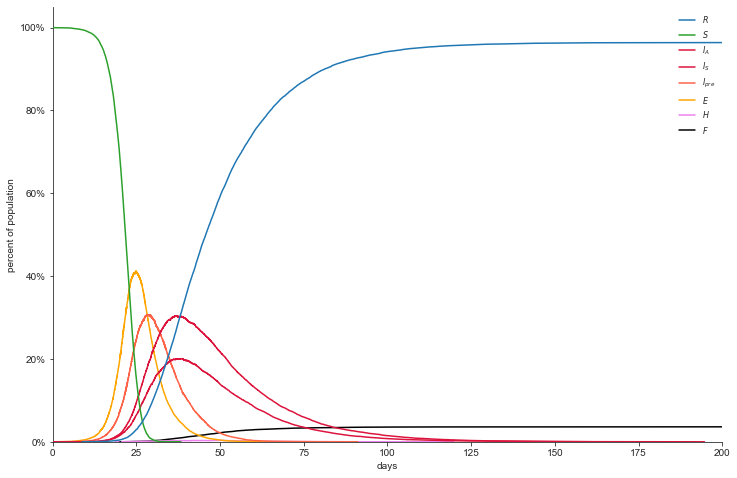

In [ ]:
fig, ax = model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.2) Running the multiple food queues model with interventions

In [ ]:
# Model construction for multiple food queues in addition to other interventions
interventions_model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, Q=quarantine_graph_4fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

interventions_model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, Q=quarantine_graph_8fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
## Interventions for graph with 4 food queues 
interventions.clear()

# Amount by which wearing masks reduces the transmission rate
reduction_percentage = 0.3

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph_4fq, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_4fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_4fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, intervention_results_4fq = run_simulation(interventions_model_4fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [26:54<00:00,  8.07s/it]  


In [ ]:
# Model name for storage - adjust accordingly to interventions
fig_name = f"InterventionsMultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18698.0      1.0                      0.0                   1.0   
1        18697.0      2.0                      0.0                   1.0   
2        18696.0      3.0                      0.0                   1.0   
3        18696.0      2.0                      1.0                   1.0   
4        18696.0      2.0                      0.0                   2.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        0.0         0.0   
3                      0.0           0.0        0.0         0.0   
4                      0.0           0.0        0.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18094.0       606.0   
196                    0.0           0.0    18094.0       606.0   
197                    0.0           0.0    18094.0       606.0   
198                    0.0           0.0    18094.0       606.0   
199                    0.0           0.0    18094.0       606.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          1     1  
1          2     2  
2          3     3  
3          4     4  
4          5     5  
..       ...   ...  
195    75435   196  
196    75435   197  
197    75435   198  
198    75435   199  
199    75435   200  

[200 rows x 13 columns]

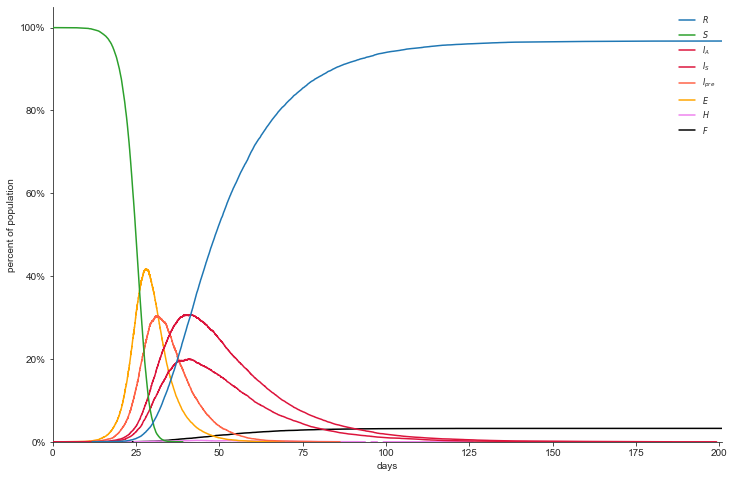

In [ ]:
fig, ax = interventions_model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
## Interventions for graph with 8 food queues 
interventions.clear()

# Simulate quarantine + masks
interventions.add(quarantine_graph_8fq, 3, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
interventions.add(graph_8fq, 63, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
interventions.add(graph_8fq, 93, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, interventions_results_8fq = run_simulation(interventions_model_8fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [1:18:36<00:00, 23.58s/it]   


In [ ]:
# Model name for storage - adjust accordingly to interventions
mean_degree = round(sum([degree for node, degree in quarantine_graph_8fq.degree])/len(quarantine_graph_8fq.degree), 3) # Get the mean degree
quarantine_duration = "3-63"

fig_name = f"InterventionsSympModel8FQ_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}_QDeg={mean_degree}_QDur={quarantine_duration}"

In [ ]:
output_df = results_to_df(interventions_results_8fq, store=True, store_name=f"results/{fig_name}.csv")

In [ ]:
output_df

Susceptible  Exposed  Infected_Presymptomatic  Infected_Symptomatic  \
0        18697.0      1.0                      1.0                   1.0   
1        18694.0      3.0                      1.0                   2.0   
2        18692.0      5.0                      1.0                   2.0   
3        18686.0      9.0                      2.0                   2.0   
4        18683.0     11.0                      3.0                   2.0   
..           ...      ...                      ...                   ...   
195          0.0      0.0                      0.0                   0.0   
196          0.0      0.0                      0.0                   0.0   
197          0.0      0.0                      0.0                   0.0   
198          0.0      0.0                      0.0                   0.0   
199          0.0      0.0                      0.0                   0.0   

     Infected_Asymptomatic  Hospitalized  Recovered  Fatalities  \
0                      0.0           0.0        0.0         0.0   
1                      0.0           0.0        0.0         0.0   
2                      0.0           0.0        0.0         0.0   
3                      1.0           0.0        0.0         0.0   
4                      1.0           0.0        0.0         0.0   
..                     ...           ...        ...         ...   
195                    0.0           0.0    18058.0       642.0   
196                    0.0           0.0    18058.0       642.0   
197                    0.0           0.0    18058.0       642.0   
198                    0.0           0.0    18058.0       642.0   
199                    0.0           0.0    18058.0       642.0   

     Detected_Presymptomatic  Detected_Symptomatic  Detected_Asymptomatic  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   0.0                    0.0   
4                        0.0                   0.0                    0.0   
..                       ...                   ...                    ...   
195                      0.0                   0.0                    0.0   
196                      0.0                   0.0                    0.0   
197                      0.0                   0.0                    0.0   
198                      0.0                   0.0                    0.0   
199                      0.0                   0.0                    0.0   

     T_index  Time  
0          3     1  
1          8     2  
2         10     3  
3         19     4  
4         23     5  
..       ...   ...  
195    75470   196  
196    75470   197  
197    75470   198  
198    75470   199  
199    75470   200  

[200 rows x 13 columns]

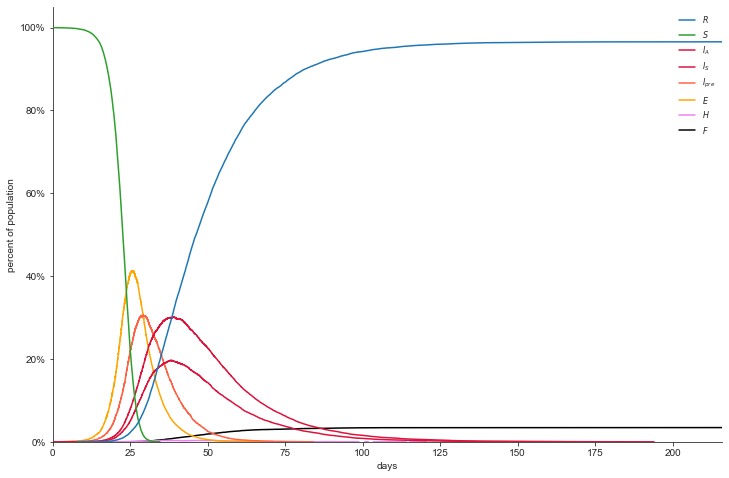

In [ ]:
fig, ax = interventions_model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")